In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42) 

n_samples = 1000


data = {
    'heart_rate': np.random.normal(140, 15, n_samples),
    'temperature': np.random.normal(37, 0.4, n_samples),
    'motion_duration': np.random.exponential(10, n_samples),
    'no_motion_duration': np.random.exponential(30, n_samples),
}

df = pd.DataFrame(data)

# New sids_risk condition without respiratory rate
df['sids_risk'] = (
    ((df['heart_rate'] < 110) | (df['heart_rate'] > 170)) |
    (df['no_motion_duration'] > 60)
).astype(int)

# Check class distribution
print(df['sids_risk'].value_counts())

# Save the DataFrame to a CSV file
df.to_csv('sids_risk_data.csv', index=False)


sids_risk
0    783
1    217
Name: count, dtype: int64


Training The Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = df.drop(['sids_risk', 'resp_rate'], axis=1)  # Drop sids_risk AND resp_rate
y = df['sids_risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       157
           1       1.00      0.98      0.99        43

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



Visualizing

Save the Model

In [20]:
import joblib

# Save model
joblib.dump(model, 'sids_risk_detector.pkl')

['sids_risk_detector.pkl']

To Load the model

In [21]:
model = joblib.load('sids_risk_detector.pkl')


Visualizing the features

C:\Users\Ab\AppData\Local\Temp\ipykernel_7348\1486337121.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


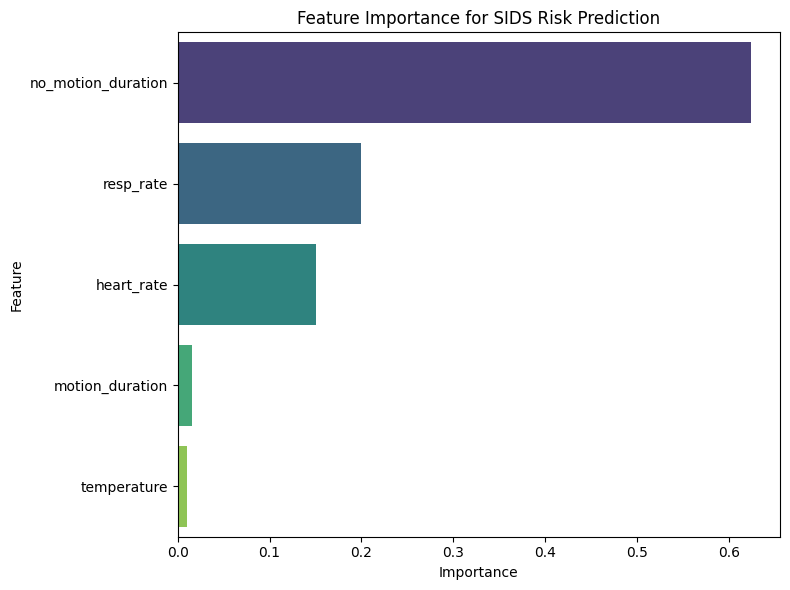

In [ ]:
# Visualize feature importance
importances = model.feature_importances_
feature_names = X.columns  # X already has 'resp_rate' removed earlier

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Feature Importance for SIDS Risk Prediction')
plt.tight_layout()
plt.show()


Plot a Confusion Matrix & ROC CurvePlot a Confusion Matrix & ROC Curve

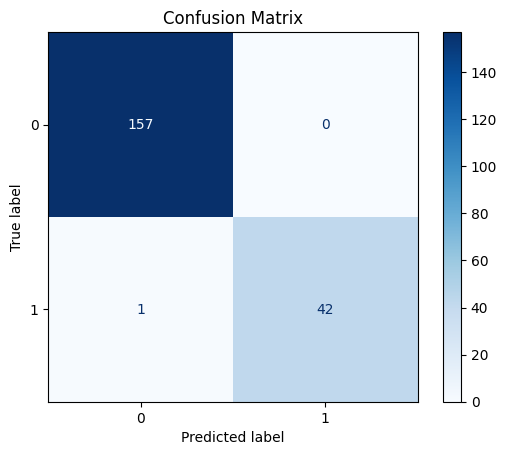

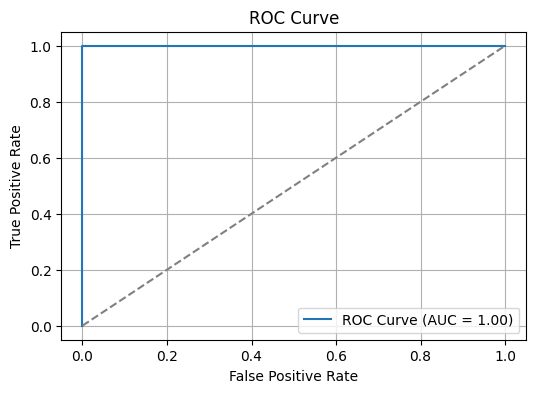

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Export Predictions to CSV

In [24]:
# Add predictions to test set
test_results = X_test.copy()
test_results['Actual'] = y_test.values
test_results['Predicted'] = y_pred
test_results['Risk_Probability'] = y_proba

# Save to CSV
test_results.to_csv('sids_predictions.csv', index=False)
